In [1]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import Onlinehd

SEED = 1234
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
from tensorflow.keras.datasets import fashion_mnist

def load():
    if dataset == 'mnist':
        (x, y), (x_test, y_test) = mnist.load_data()
    elif dataset == 'fashion_mnist':
        (x, y), (x_test, y_test) = fashion_mnist.load_data()
    else:
        temp = EMNIST('./data/EMNIST', split = 'letters', train=True, download=True)
        x = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
        y = temp.targets.numpy() - 1
        temp = EMNIST('./data/EMNIST', split='letters', train=False, download=True)
        x_test = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
        y_test = temp.targets.numpy() - 1
        
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long().squeeze()

    if len(x.shape) != 3:
        x = x.squeeze(3)
        x_test = x_test.squeeze(3)
    
    return x, x_test, y, y_test

In [5]:
dataset = 'fashion_mnist' # dataset can be 'fashion_mnist', 'mnist', or  'emnist'


x, x_test, y, y_test = load()

In [6]:
x = x.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

scaler = sklearn.preprocessing.Normalizer().fit(x.reshape(-1, 784))
x = torch.tensor(scaler.transform(x.reshape(-1, 784)))
x_test = torch.tensor(scaler.transform(x_test.reshape(-1, 784)))

In [8]:
classes = y.unique().size(0)
features = x.size(1)
model = Onlinehd.OnlineHD(classes, features, dim=10000)

if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
model = model.fit(x, y, bootstrap=1.0, lr=0.035, epochs=20)
t = time() - t

Training...
0
10


In [9]:
print('Validating...')
yhat = model(x)
yhat_test = model(x_test)
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')

Validating...
acc = 0.833617
acc_test = 0.819600
t = 32.590231


# JSMA

In [10]:

from abc import ABCMeta

import torch

def replicate_input(x):
    return x.detach().clone()

class Attack(object):
    """
    Abstract base class for all attack classes.
    :param predict: forward pass function.
    :param loss_fn: loss function that takes .
    :param clip_min: mininum value per input dimension.
    :param clip_max: maximum value per input dimension.
    """

    __metaclass__ = ABCMeta

    def __init__(self, predict, loss_fn, clip_min, clip_max):
        """Create an Attack instance."""
        self.predict = predict
        self.loss_fn = loss_fn
        self.clip_min = clip_min
        self.clip_max = clip_max

    def perturb(self, x, **kwargs):
        """Virtual method for generating the adversarial examples.
        :param x: the model's input tensor.
        :param **kwargs: optional parameters used by child classes.
        :return: adversarial examples.
        """
        error = "Sub-classes must implement perturb."
        raise NotImplementedError(error)

    def __call__(self, *args, **kwargs):
        return self.perturb(*args, **kwargs)


class LabelMixin(object):
    def _get_predicted_label(self, x):
        """
        Compute predicted labels given x. Used to prevent label leaking
        during adversarial training.
        :param x: the model's input tensor.
        :return: tensor containing predicted labels.
        """
        with torch.no_grad():
            outputs = self.predict(x)
        _, y = torch.max(outputs, dim=1)
        return y

    def _verify_and_process_inputs(self, x, y):
        if self.targeted:
            assert y is not None

        if not self.targeted:
            if y is None:
                y = self._get_predicted_label(x)

        x = replicate_input(x)
        y = replicate_input(y)
        return x, y

In [11]:
class JacobianSaliencyMapAttack():
    """
    Jacobian Saliency Map Attack
    This includes Algorithm 1 and 3 in v1, https://arxiv.org/abs/1511.07528v1
    :param predict: forward pass function.
    :param num_classes: number of clasess.
    :param clip_min: mininum value per input dimension.
    :param clip_max: maximum value per input dimension.
    :param gamma: highest percentage of pixels can be modified
    :param theta: perturb length, range is either [theta, 0], [0, theta]
    """

    def __init__(self, predict, num_classes=10,
                 clip_min=0.0, clip_max=1.0, loss_fn=None,
                 theta=1.0, gamma=1.0, comply_cleverhans=False):
        
        self.clip_max = clip_max
        self.clip_min = clip_min
        self.predict = predict
        self.num_classes = num_classes
        self.theta = theta
        self.gamma = gamma
        self.comply_cleverhans = comply_cleverhans
        self.targeted = True

    def _compute_forward_derivative(self, xadv, y):
        jacobians = torch.stack([jacobian(self.predict, xadv, yadv)
                                 for yadv in range(self.num_classes)])
        grads = jacobians.view((jacobians.shape[0], jacobians.shape[1], -1))
        grads_target = grads[y, range(len(y)), :]
        grads_other = grads.sum(dim=0) - grads_target
        return grads_target, grads_other

    def _sum_pair(self, grads, dim_x):
        return grads.view(-1, dim_x, 1) + grads.view(-1, 1, dim_x)

    def _and_pair(self, cond, dim_x):
        return cond.view(-1, dim_x, 1) & cond.view(-1, 1, dim_x)

    def _saliency_map(self, search_space, grads_target, grads_other, y):

        dim_x = search_space.shape[1]

        # alpha in Algorithm 3 line 2
        gradsum_target = self._sum_pair(grads_target, dim_x)
        # alpha in Algorithm 3 line 3
        gradsum_other = self._sum_pair(grads_other, dim_x)

        if self.theta > 0:
            scores_mask = (torch.gt(gradsum_target, 0) &
                           torch.lt(gradsum_other, 0))
        else:
            scores_mask = (torch.lt(gradsum_target, 0) &
                           torch.gt(gradsum_other, 0))

        scores_mask &= self._and_pair(search_space.ne(0), dim_x)
        scores_mask[:, range(dim_x), range(dim_x)] = 0

        if self.comply_cleverhans:
            valid = torch.ones(scores_mask.shape[0]).byte()
        else:
            valid = scores_mask.view(-1, dim_x * dim_x).any(dim=1)

        scores = scores_mask.float() * (-gradsum_target * gradsum_other)
        best = torch.max(scores.view(-1, dim_x * dim_x), 1)[1]
        p1 = torch.remainder(best, dim_x)
        p2 = (best / dim_x).long()
        return p1, p2, valid

    def _modify_xadv(self, xadv, batch_size, cond, p1, p2):
        ori_shape = xadv.shape
        xadv = xadv.view(batch_size, -1)
        for idx in range(batch_size):
            if cond[idx] != 0:
                xadv[idx, p1[idx]] += self.theta
                xadv[idx, p2[idx]] += self.theta
        xadv = clamp(xadv, min=self.clip_min, max=self.clip_max)
        xadv = xadv.view(ori_shape)
        return xadv

    def _update_search_space(self, search_space, p1, p2, cond):
        for idx in range(len(cond)):
            if cond[idx] != 0:
                search_space[idx, p1[idx]] -= 1
                search_space[idx, p2[idx]] -= 1

    def perturb(self, x, y=None):
#         x, y = self._verify_and_process_inputs(x, y)
        xadv = x.clone()
        batch_size = 1
        dim_x = 784
        max_iters = int(dim_x * self.gamma / 2)
        search_space = x.new_ones(batch_size, dim_x).int()
        curr_step = 0
        yadv = model(xadv)
        
        self.clip_max = x.max().item()
        self.clip_min = x.min().item()

        # Algorithm 1        
        while ((y != yadv).any() and curr_step < 10):
            grads_target, grads_other = self._compute_forward_derivative(xadv, y)
            # Algorithm 3
            p1, p2, valid = self._saliency_map(
                search_space, grads_target, grads_other, y)

            cond = (y != yadv) & valid

            self._update_search_space(search_space, p1, p2, cond)

            xadv = self._modify_xadv(xadv, batch_size, cond, p1, p2)
            yadv = model(xadv)

            curr_step += 1

        xadv = clamp(xadv, min=self.clip_min, max=self.clip_max)
        return xadv

In [12]:
def jacobian(model, x, output_class):
    """
    Compute the output_class'th row of a Jacobian matrix. In other words,
    compute the gradient wrt to the output_class.
    :param model: forward pass function.
    :param x: input tensor.
    :param output_class: the output class we want to compute the gradients.
    :return: output_class'th row of the Jacobian matrix wrt x.
    """

    xvar = x.detach().clone()
    xvar.requires_grad = True
    scores = model.scores(xvar)

    # compute gradients for the class output_class wrt the input x
    # using backpropagation
    torch.sum(scores[:, output_class]).backward()

    return xvar.grad.detach().clone()

In [13]:
def clamp(input, min=None, max=None):
    ndim = input.ndimension()
    if min is None:
        pass
    elif isinstance(min, (float, int)):
        input = torch.clamp(input, min=min)
    elif isinstance(min, torch.Tensor):
        if min.ndimension() == ndim - 1 and min.shape == input.shape[1:]:
            input = torch.max(input, min.view(1, *min.shape))
        else:
            assert min.shape == input.shape
            input = torch.max(input, min)
    else:
        raise ValueError("min can only be None | float | torch.Tensor")

    if max is None:
        pass
    elif isinstance(max, (float, int)):
        input = torch.clamp(input, max=max)
    elif isinstance(max, torch.Tensor):
        if max.ndimension() == ndim - 1 and max.shape == input.shape[1:]:
            input = torch.min(input, max.view(1, *max.shape))
        else:
            assert max.shape == input.shape
            input = torch.min(input, max)
    else:
        raise ValueError("max can only be None | float | torch.Tensor")
    return input


In [14]:
JSMA = JacobianSaliencyMapAttack(model)

In [15]:
from tqdm import tqdm
xadv = torch.zeros(17500, 784)

for i in tqdm(range(17500)):
    xadv[i] = JSMA.perturb(x_test[i].reshape(1, 784), y[i].reshape(1))

 57%|████████████████████               | 10000/17500 [1:17:24<58:03,  2.15it/s]


IndexError: index 10000 is out of bounds for dimension 0 with size 10000

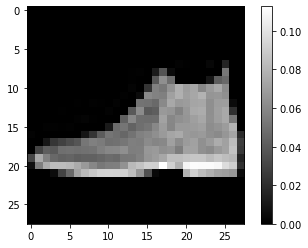

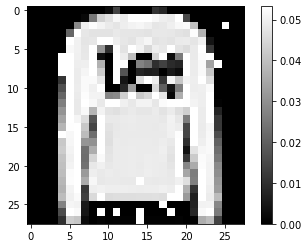

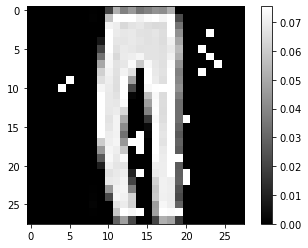

In [16]:
for i in range(3):
    plt.imshow(xadv[i].reshape(28, 28), cmap='gray')
    plt.colorbar()
    plt.show()

In [17]:
adv_samples = torch.from_numpy(scaler.transform(xadv[:10000])).float()

In [18]:
print('Validating...')
yhat = model(x)
yhat_test = model(x_test)
yhat_attack = model(adv_samples.reshape(-1, 784))


acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
acc_attack = (y_test == yhat_attack).float().mean()

print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{acc_attack = :6f}')
print(f'{t = :6f}')

Validating...
acc = 0.833617
acc_test = 0.819600
acc_attack = 0.789600
t = 32.590231


In [19]:
import pickle

data = {
    'data':adv_samples,
    'label':y_test
}

with open('FMNIST_HD_JSMA.pickle', 'wb') as f:
    pickle.dump(data, f)